## Pyplatefit tutorial

<div style="font-size:2em; font-weight:bolder;">Pyplatefit tutorial</div>

<div style="font-size:1em; font-weight:bolder;">Roland Bacon</div>

### Introduction

**Pyplatefit** is a python module to perform emission line fitting of astronomical spectra. Although it has been developed for the MUSE integral field spectrograph, it should work for spectrum delivered by other instruments, provided that the input spectrum is in MPDAF format.

The program take as input a spectrum and an input redshift and return the list of emission lines parameters: e.g. flux, velocity dispersion, equivalent width and their errors. The program perform a continuum fit, using a simple population model and then fit the emission lines after continuum subtraction. In addition the program can also perform basic absorption lines fit.

Lines are organized into families. All lines from the same family share the same velocity (or redshift) and velocity dispersion. In addition to the two **Balmer** and **Forbidden** families, resonnant lines like ${\rm Ly\alpha}$ or ${\rm Mg_{II}}$ are fitted separately as distinct families. Absorption lines are also processed as a separate family. Each family is fitted independantly.

All emission (and absorption) lines are modelled as Gaussians with 3 parameters: velocity, velocity dispersion (in ${\rm km s^{-1}}$) and flux. The only exception, is the ${\rm Ly\alpha}$ line which is fitted as a [skewed Gaussian](https://en.wikipedia.org/wiki/Skew_normal_distribution), with an additional ${\rm \gamma}$ parameter measing the asymetry of the line.
$$
{\rm F(\lambda) = F_{max} \left[ 1 + erf \left( \gamma \frac{\left(\lambda - \lambda_{0}\right)}{\sqrt 2 \sigma} \right) \right] 
\left[ exp \left( - \frac{\left(\lambda - \lambda_{0}\right)^2}{2 \sigma^2} \right) \right] }
$$

Optionnaly, double peaked ${\rm Ly\alpha}$ line can be fitted as the sum of two skewed Gaussians.

The program use the front-end [lmfit](https://lmfit.github.io/lmfit-py) minimization package based on [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) non-linear least-squares minimization. The default minimization routine is the [Trust Region Reflective least squares algorithm](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.45.9964), which is more robust and gives better estimate error estimate than the classical Levenberg–Marquardt algorithm. Other minimization algorithm can be selected, see [lmfit documentation](https://lmfit.github.io/lmfit-py/fitting.html#the-minimize-function) for detail. The MCMC [emcee](https://emcee.readthedocs.io/en/stable/) package is also used to improve error computation.



### Importing modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import mpdaf, pyplatefit
from mpdaf.obj import Spectrum
from pyplatefit import fit_spec, plot_fit, print_res
print(f"MPDAF version {mpdaf.__version__}")
print(f"Pyplatefit version {pyplatefit.__version__}")

MPDAF version 3.6.dev0+g402ca7a7.d20210310
Pyplatefit version 0.7


### Basic usage

#### Input data

The input spectrum must be in MPDAF format, ie with proper wcs information and data and variance extensions. See [MPDAF documentation](https://mpdaf.readthedocs.io/en/latest/api/mpdaf.obj.Spectrum.html#mpdaf.obj.Spectrum) for more detailed information.
The input redshift **z** (in vacuum) must be precise enough. Pyplatefit will refine it but cannot deal with poorly known redshift.

In [2]:
datadir = '../tests/test_data'
sp = Spectrum(os.path.join(datadir, 'udf10_00002.fits'))
sp.info()

[INFO] 3681 Spectrum (../tests/test_data/udf10_00002.fits)
[INFO] .data(3681) (1e-20 erg / (Angstrom cm2 s)), .var(3681)
[INFO] wavelength: min:4750.00 max:9350.00 step:1.25 Angstrom


#### Running the minimisation

**fit_spec** is the main routine, see later for the meaning of all input parameters.

In [3]:
res = fit_spec(sp, z=0.41892)

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 21.3 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Found 2 non resonnant line families to fit
[DEBUG] Init Fit of family balmer
[DEBUG] Found 9 lines to fit
[DEBUG] added 9 gaussian to the fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 13 lines to fit
[DEBUG] added 13 gaussian to the fit
[DEBUG] Found 0 resonnant line families to fit
[DEBUG] Fitting of Line Family: balmer
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 7 iterations, reached minimum = 192511.056 and redChi2 = 249.367
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 9 iterations, reached minimum = 196213.255 and redChi2 = 255.486
[DEBUG] Saving balmer results to tabline

By default the logging is in **DEBUG** mode, but it is possible to run it in quiet mode, using the python [logging](https://docs.python.org/3/howto/logging.html) module.

In [4]:
import logging
logger = logging.getLogger('pyplatefit')
logger.setLevel('INFO')
res = fit_spec(sp, z=0.41892)
logger.setLevel('DEBUG')

#### Analysis of result

The program return a python dictionary with a following items: 

- ztable: the redshift table (astropy format)
- lines: the lines table (astropy format)
- spec_fit: the fitted spectrum (MPDAF format)

Note that the resulting dictionary include many other items. We describe here only the ones relevant for this basic usage. More is given later in the advanced usage section.

The **ztable** contain global information for each fitted family.

In [5]:
res['ztable']

FAMILY,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDISP,VDISP_ERR,LINE,SNRMAX,SNRSUM,SNRSUM_CLIPPED,NL,NL_CLIPPED,RCHI2,NFEV,STATUS,METHOD
str20,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,int64,int64,float64,int64,int64,str25
balmer,82.13,3.86,0.41931,1.83e-05,0.41892,66.11,4.26,HBETA,20.62,13.28,12.98,9,5,249.37,7,3,least_squares
forbidden,92.49,5.29,0.41936,2.50e-05,0.41892,66.65,6.07,OII3727b,17.26,16.86,20.72,12,5,255.49,9,3,least_squares


In this case the fit converge to similar velocity (**VEL**) and velocity dispersion (**VDISP**) for the balmer and forbidden lines. The highest **SNRMAX** and corresponding **LINE** are reported. The number of fitted lines before (**NL**) and after SNR>3 clipping (**NL_CLIPPED**) are also given. An relevant parameter is the SNR sum of the clipped lines (**SNRSUM_CLIPPED**). The convergence status (**STATUS**), number of function evaluation (**NFEV**), reduced $\chi^2$ (**RCHI2**) and name of the algorithm (**METHOD**) are also given.
Codification of convergence status is specific for each method, for the default **least_squares** (Trust Reflective Least Square) method
see the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares). When convergence is achieved we expect to get status=3, and status=0 if the algorithm did not converge in the maximum of iterations.

The detailed information for each fitted lines is given in the **lines** table.
In the following we list the five highest SNR emission lines, excluding the blended lines (e.g OII3727b = OII3726+OII3729).

In [6]:
lines = res['lines'].copy()
lines = lines[~lines['ISBLEND']]
lines.sort('SNR')
lines[::-1][0:5]

FAMILY,LINE,ISBLEND,LBDA_REST,DNAME,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDINST,VDISP,VDISP_ERR,FLUX,FLUX_ERR,SNR,SKEW,SKEW_ERR,LBDA_OBS,PEAK_OBS,LBDA_LEFT,LBDA_RIGHT,FWHM_OBS,NSTD,LBDA_LNSTD,LBDA_RNSTD,BLEND,EQW,EQW_ERR,CONT_OBS,CONT,CONT_ERR
str20,str20,bool,float64,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
balmer,HBETA,False,4862.68,Hβ,82.13,3.86,0.41931,1.83e-05,0.41892,42.93,66.11,4.26,8567.47,415.43,20.62,0.00,0.00,6899.74,1884.01,6897.60,6901.87,4.27,-2.19,6893.33,6906.15,0,-7.86,0.40,768.17,1089.98,30.89
forbidden,OII3729,False,3729.88,[Oɪɪ],92.49,5.29,0.41936,2.50e-05,0.41892,61.97,66.65,6.07,6065.85,435.24,13.94,0.00,0.00,5292.56,1506.24,5290.67,5294.45,3.78,-2.44,5282.93,5298.23,3727,-7.20,0.55,593.92,842.73,42.22
forbidden,NII6584,False,6585.28,None,92.49,5.29,0.41936,2.50e-05,0.41892,33.19,66.65,6.07,11604.35,1017.52,11.40,0.00,0.00,9344.30,1994.89,9341.57,9347.03,5.47,-1.79,9336.10,9352.50,0,-11.65,1.45,701.99,996.06,292.68
balmer,HGAMMA,False,4341.68,Hγ,82.13,3.86,0.41931,1.83e-05,0.41892,49.80,66.11,4.26,3647.94,348.92,10.45,0.00,0.00,6160.48,855.67,6158.47,6162.48,4.01,-1.85,6154.47,6166.49,0,-3.28,0.32,784.02,1112.46,36.08
forbidden,OII3726,False,3727.09,None,92.49,5.29,0.41936,2.50e-05,0.41892,62.04,66.65,6.07,4340.88,426.09,10.19,0.00,0.00,5288.60,1078.16,5286.71,5290.49,3.78,-2.44,5282.93,5298.23,3727,-5.19,0.53,589.73,836.78,41.88


The detailed explanation of all columns is given in appendix. Note that parameters (unless specfified by **OBS** in the column name) are given in rest frame. Velocity dispersion (**VDISP**) is corrected for MUSE instrumental resolution.

A visual check can be performed with the **plot_fit** routine.

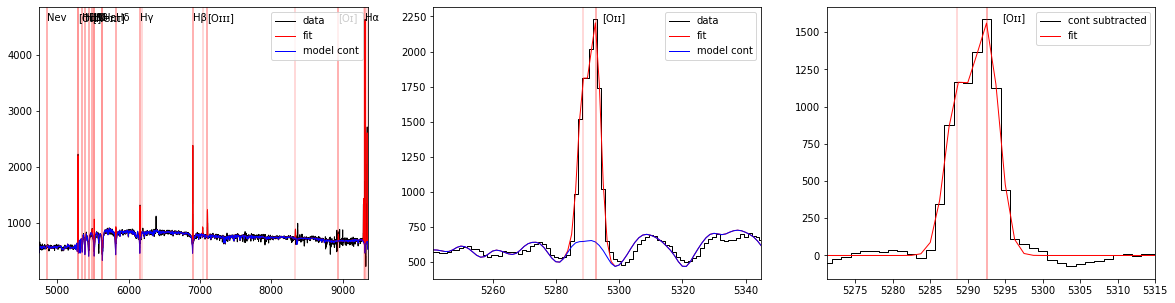

In [7]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
plot_fit(ax[0], res)
plot_fit(ax[1], res, line='OII3729')
plot_fit(ax[2], res, line='OII3729', line_only=True, margin=20)

The left panel display the full spectrum (in black) and its continuum fit (in blue) with the location of fitted lines (in red). The central panel display a zoom on the [OII] doublet and the right panel the continuum subtracted spectrum.

#### Improving continuum fit

From the central panel of the previous plot, one can see that the continuum fit (in blue) is slightly offseted with respect to the data. The reason is that the continuum estimation performed in the first step of the fitting process use a fixed value of z, as given by the input redshift. In that case it is wise to use  **ziter=True** in fit_spec to allow a second iteration.

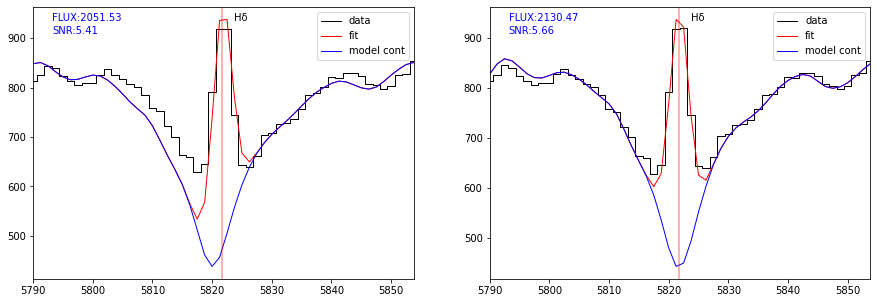

In [8]:
logger = logging.getLogger('pyplatefit')
logger.setLevel('INFO')
res2 = fit_spec(sp, z=0.41892, ziter=True)
logger.setLevel('DEBUG')
fig,ax = plt.subplots(1,2,figsize=(15,5))
plot_fit(ax[0], res, line='HDELTA', margin=30, infoline=['FLUX','SNR'])
plot_fit(ax[1], res2, line='HDELTA', margin=30, infoline=['FLUX','SNR'])

#### Fitting all lines together

In some case, it is better to fit all lines together rather than splitting the fit by families.
This is done with the **fit_all=True** flag. 

Note that ${\rm Ly\alpha}$, given its systematic offset with respect to the systemic velocity, is still fitted separatly.

In [9]:
logger.setLevel('INFO')
res = fit_spec(sp, z=0.41892, ziter=True, fit_all=True)
logger.setLevel('DEBUG')
res['ztable']

FAMILY,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDISP,VDISP_ERR,LINE,SNRMAX,SNRSUM,SNRSUM_CLIPPED,NL,NL_CLIPPED,RCHI2,NFEV,STATUS,METHOD
str20,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,int64,int64,float64,int64,int64,str25
all,3.54,0.71,0.41934,3.38e-06,0.41933,64.55,0.80,HBETA,90.47,75.41,88.28,21,16,14.48,8,3,least_squares


#### Working with ${\rm Ly\alpha}$

The ${\rm Ly\alpha}$ line is often the only line available at high z. It is generally broad and asymmetric and then it is better fitted with the skewed gaussian model.

In [10]:
sp = Spectrum(os.path.join(datadir,'udf10_00723.fits'))
res = fit_spec(sp, z=3.18817)

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 16.7 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Init Lya Fit
[DEBUG] added 1 asymetric gaussian to the fit
[DEBUG] Found 1 non resonnant line families to fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 14 lines to fit
[DEBUG] added 14 gaussian to the fit
[DEBUG] Found 1 resonnant line families to fit
[DEBUG] Init fitting of family civ1548
[DEBUG] Found 2 lines to fit
[DEBUG] added 2 gaussian to the fit
[DEBUG] Fitting of Line Family: lya
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 11 iterations, reached minimum = 188.100 and redChi2 = 0.308
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] Both `ftol` and `xtol` termination conditions are satisfied. after 16 iterations, reached

In the output debug log, one can see that the continuum fit failed. This is the case when the cotniuum is too faint, then a constant is used (median of the continuum).

We also see that in addition to forbidden lines, ${\rm Ly\alpha}$ and the resonnant CIV doublet were fitted separately.
However when looking to the **ztable**, we see that all lines except ${\rm Ly\alpha}$ are below the detection limit.

In [11]:
res['ztable']

FAMILY,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDISP,VDISP_ERR,LINE,SNRMAX,SNRSUM,SNRSUM_CLIPPED,NL,NL_CLIPPED,RCHI2,NFEV,STATUS,METHOD
str20,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,int64,int64,float64,int64,int64,str25
civ1548,120.59,50.63,3.18985,7.07e-04,3.18817,50.05,68.64,CIV1549b,1.54,1.54,0.00,1,0,0.35,14,3,least_squares
forbidden,-121.11,151.50,3.18648,2.12e-03,3.18817,300.00,124.47,SiIV1403b,1.56,2.08,0.00,8,0,0.35,16,4,least_squares
lyalpha,37.03,21.98,3.18869,3.07e-04,3.18817,263.96,49.61,LYALPHA,7.31,7.31,7.31,1,1,0.31,11,3,least_squares


As shown in the following plot, the ${\rm Ly\alpha}$ line is well fitted by a skewed Gaussian with $\gamma$ positive (**SKEW** = 8.4), confirming the strong red asymetry of the line profile.

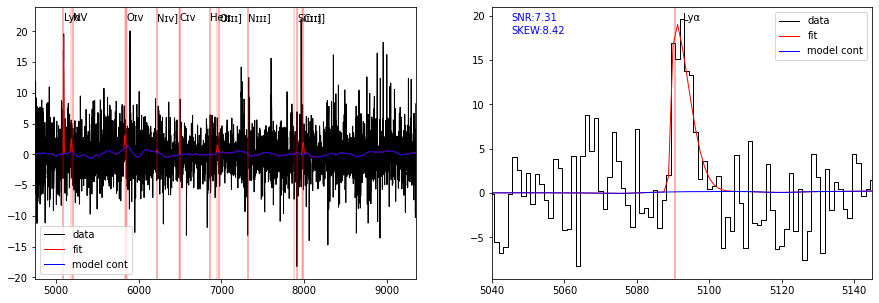

In [12]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
plot_fit(ax[0], res)
plot_fit(ax[1], res, line='LYALPHA', infoline=['SNR','SKEW'])

When the initial redshift is poorly known the fit might not converge to the right solution. One can check the provided initial solution with the **start=True** option in the **plot_line**. As shown in the left panel of the above plot, the initial solution (in blue) was too far from the left peak to converge to the solution. 

In that case it is possible to use the option flag **find_lya_vel_offset=True** in **fit_spec** to perform an initail peak search prior to the fit. As it can be seen from the right panel, this help the process to converge to the solution.

*However, this option must be used with care as it can easily pick another peaked as initial solution.*


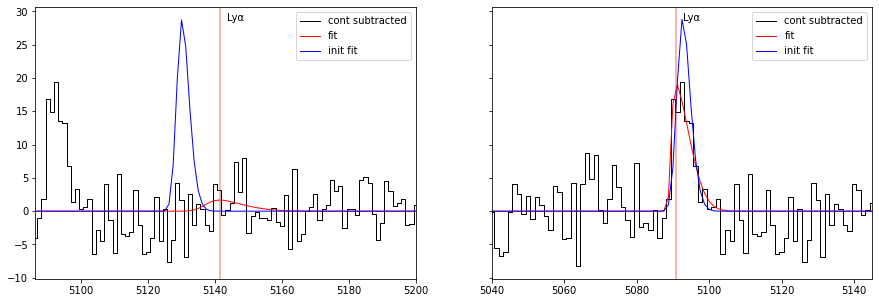

In [13]:
logger.setLevel('INFO')
res = fit_spec(sp, z=3.22)
res2 = fit_spec(sp, z=3.22, find_lya_vel_offset=True)
fig,ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
plot_fit(ax[0], res, line='LYALPHA', start=True, line_only=True)
plot_fit(ax[1], res2, line='LYALPHA', start=True, line_only=True)

#### Double peaked ${\rm Ly\alpha}$ line profile

In some case, the ${\rm Ly\alpha}$ line profile can display a blue bump or even a double peak. In that case we can use the option flag **dble_lyafit=True** to perform the double skewed gaussain fit.

In [14]:
sp = Spectrum(os.path.join(datadir,'udf10_00106.fits'))
res = fit_spec(sp, z=3.27554, dble_lyafit=True)

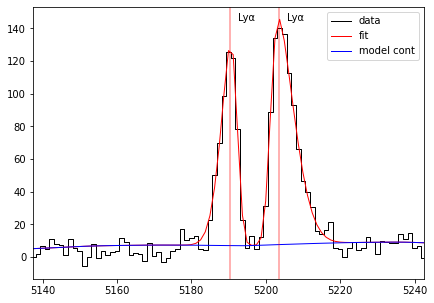

In [15]:
fig,ax = plt.subplots(1,1,figsize=(7,5),sharey=True)
plot_fit(ax, res, line='LYALPHA1')

The two line peaks are fitted together with two skewed gaussian. The two profiles are names **LYALPHA1** and **LYALPHA2** for the blue and red components respectively. The paramaters of the fit are the velocity (or redshift) measured as the center of the peak separation (**SEP**), the flux, velocity dispersion and skewness of each peak. Note that the redshit given by this fit is the center of the two peaks and not the peak of the line as it is for a single line fit.

In [16]:
lines = res['lines'].copy()
lines = lines[~lines['ISBLEND']]
lines[lines['FAMILY']=='lyalpha']['LINE','VEL','Z','SEP','VDISP','FLUX','SKEW']

LINE,VEL,Z,SEP,VDISP,FLUX,SKEW
str20,float64,float64,float64,float64,float64,float64
LYALPHA1,34.18,3.27603,515.83,194.33,680.34,-2.78
LYALPHA2,34.18,3.27603,515.83,307.58,1080.47,4.04


#### Working with doublets and blends

Many lines are double (or more) which can be marginally resolved at the instrumental spectral resolution. For these lines, the fit report the parameters of each lines but also for the blend, adding a **b** at the end of the line name (eg OII3727b). The returned table has a **BLEND** column flag which allow to filter in/out these lines.

In [17]:
sp = Spectrum(os.path.join(datadir,'mosaic_01102.fits'))
res1 = fit_spec(sp, z=0.6198)
lines = res1['lines'].copy()
lines[lines['ISBLEND']]

FAMILY,LINE,ISBLEND,LBDA_REST,DNAME,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDINST,VDISP,VDISP_ERR,FLUX,FLUX_ERR,SNR,SKEW,SKEW_ERR,LBDA_OBS,PEAK_OBS,LBDA_LEFT,LBDA_RIGHT,FWHM_OBS,NSTD,LBDA_LNSTD,LBDA_RNSTD,BLEND,EQW,EQW_ERR,CONT_OBS,CONT,CONT_ERR
str20,str20,bool,float64,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
forbidden,OII3727b,True,3728.48,[Oɪɪ],5.98,11.07,0.61983,5.98e-05,0.61980,0.00,37.40,15.08,165.30,27.75,5.96,0.00,0.00,6037.85,32.01,6034.08,6041.61,3.01,0.00,0.00,0.00,3727,-10.51,2.48,9.71,15.73,12.24


In some case we may also want to constrain the line ratios to avoid unphysical fit. This is activated with the option flag **use_line_ratios=True**. 

By default the following line ratios are defined:

${\rm \left( 0.3 < \frac{OII_{3729}}{OII_{3726}} < 1.5 \right)}$ and 
${\rm \left( 0.6 < \frac{CIII_{1909}}{CIII_{1907}} < 1.2 \right)}$

We will see later how to define new lines ratio.

In [18]:
res2 = fit_spec(sp, z=0.6198, use_line_ratios=True)
for res in [res1,res2]:
    lines = res['lines'].copy()
    r1 = lines[lines['LINE']=='OII3726'][0]
    r2 = lines[lines['LINE']=='OII3729'][0]
    r21 = r2['FLUX']/r1['FLUX']
    print('ratio: ',r21)

ratio:  1.6316695024665604
ratio:  1.4999997928730038


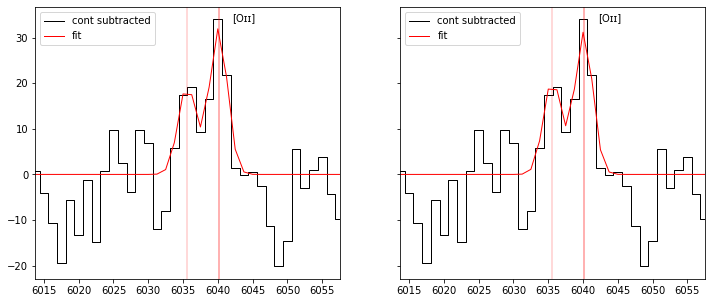

In [19]:
fig,ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
plot_fit(ax[0], res1, line='OII3726', line_only=True, margin=20)
plot_fit(ax[1], res2, line='OII3726', line_only=True, margin=20)

#### Fitting absorption lines

The program offer an option to fit absorption lines. This is activated with the flag **fitabs=True**.
The absorption lines fit is performed in a third step, after the emission line fit. The emission lines are subtracted from the original spectrum, a polynomial is performed to subtract the low order continuum and then all absorption lines are fitted simultaneously similarely to the emission line fit.

*Note that, in the case of strong emission lines, the lines residuals left by the emission line fitting, together with the accuracy of the polynomial continuum fit, may lead to inaccurate results in the absorption lines fit.*  

In [20]:
sp = Spectrum(os.path.join(datadir,'DR2_001028.fits'))
res = fit_spec(sp, z=1.90578, fitabs=True)

In [21]:
res['ztable']

FAMILY,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDISP,VDISP_ERR,LINE,SNRMAX,SNRSUM,SNRSUM_CLIPPED,NL,NL_CLIPPED,RCHI2,NFEV,STATUS,METHOD
str20,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,int64,int64,float64,int64,int64,str25
forbidden,-52.84,34.80,1.90527,3.37e-04,1.90578,88.02,31.01,CII2326b,2.78,4.21,0.00,8,0,1.26,18,3,least_squares
mgii2796,279.76,17.56,1.90849,1.70e-04,1.90578,56.51,21.07,MgII2799b,4.72,4.72,4.72,1,1,1.29,27,3,least_squares
abs,-16.32,5.77,1.90562,5.60e-05,1.90578,116.56,6.00,MgII2799b,16.50,23.97,28.58,10,8,0.74,6,3,least_squares


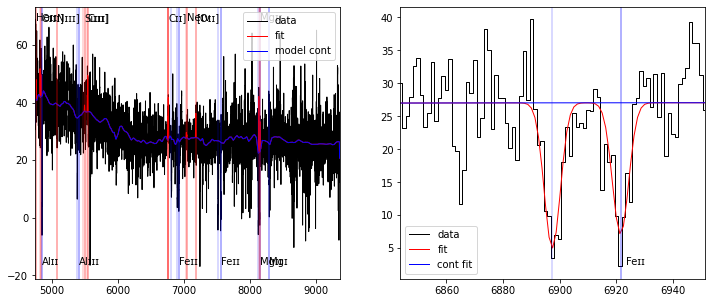

In [22]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
plot_fit(ax[0], res)
plot_fit(ax[1], res, line='FeII2374', abs_line=True)

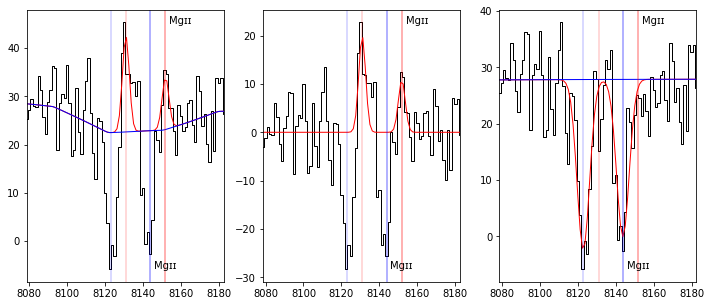

In [23]:
fig,ax = plt.subplots(1,3,figsize=(12,5))
plot_fit(ax[0], res, line='MgII2796', legend=False)
plot_fit(ax[1], res, line='MgII2796', line_only=True, legend=False)
plot_fit(ax[2], res, line='MgII2796', abs_line=True, legend=False)

One can see in these last plots that both MgII absorptions and the resonnant MgII emission doublet are raisonably well fitted.

For passive galaxy with no emission line, one can also skip the emission line fitting by setting the **fitlines=False** flag.

In [24]:
res = fit_spec(sp, z=1.90578, fitabs=True, fitlines=False)
res['ztable']

FAMILY,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDISP,VDISP_ERR,LINE,SNRMAX,SNRSUM,SNRSUM_CLIPPED,NL,NL_CLIPPED,RCHI2,NFEV,STATUS,METHOD
str20,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,int64,int64,float64,int64,int64,str25
abs,-21.17,5.63,1.90557,5.45e-05,1.90578,108.82,5.93,MgII2799b,15.76,23.26,27.75,10,8,0.79,7,3,least_squares


#### Fitting accuracy

To judge the fit accuracy pyplatefit provide two indicators:

The reduced chi square value for the simultaneous fit of all lines for each family. This value is given by the lmfit least square routine. 

To assess the goodness of the fit for each individual lines, the parameter **NSTD** is returned in the lines table. NSTD is the log10 of the standard deviation of the residuals after normalisation of the flux by the total model flux. Computation is performed in a window centered on the line peak with a width relative to the FWHM of the line. The window wavelengths limits are saved in the table as LBDA_LNSTD and LBDA_RNSTD. The smaller NSTD, the better. Typical good line fit have NSTD lower than -2.

In [25]:
sp = Spectrum(os.path.join(datadir,'udf10_00002.fits'))
res1 = fit_spec(sp, z=0.41892)
res2 = fit_spec(sp, z=0.41892, linepars=dict(vdisp=(100,150,300)))

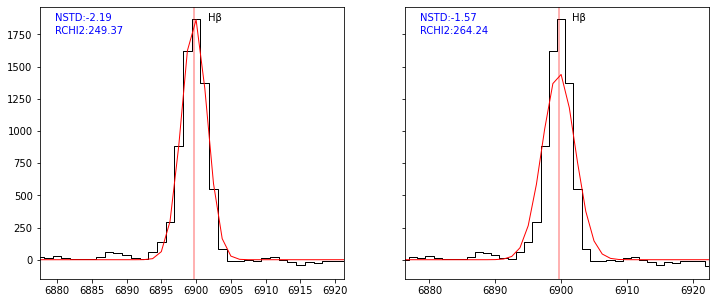

In [26]:
fig,ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
kw = dict(line='HBETA', line_only=True, margin=20, infoline=['NSTD'], infoz=['RCHI2'], legend=False)
plot_fit(ax[0], res1, **kw)
plot_fit(ax[1], res2, **kw)

### Improving error estimate using MCMC

Although the lmfit least square routine provide in general a reasonnable estimation of errors, it may give wrong results when the line is very noisy or when model parameters are strongly correlated. This is for example the case for the double ${\rm Ly\alpha}$ line fit. 

In that case, pyplatefit has an option to evaluate the errors using Markov Chain Monte Carlo using the [emcee](https://emcee.readthedocs.io/en/stable/) python module, through the lmfit interface. These options are set with two boolean flags: **mcmc_lya** and **mcmc_all**, to run the MCMC for respectively only the ${\rm Ly\alpha}$ line or all emission and absorption lines.

Please note that this option is quite **cpu intensive** and thus it is recommended to activate only if this is requested.

We use the previous example to show how it works. We compare the ${\rm Ly\alpha}$ fit with and without the MCMC option. 

In [27]:
sp = Spectrum(os.path.join(datadir,'udf10_00723.fits'))
res0 = fit_spec(sp, z=3.18817, lines=['LYALPHA'])

In [28]:
logger.setLevel('DEBUG')
sp = Spectrum(os.path.join(datadir,'udf10_00723.fits'))
res1 = fit_spec(sp, z=3.18817, lines=['LYALPHA'], mcmc_lya=True)

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 1.9 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Init Lya Fit
[DEBUG] added 1 asymetric gaussian to the fit
[DEBUG] Found 0 non resonnant line families to fit
[DEBUG] Found 0 resonnant line families to fit
[DEBUG] Fitting of Line Family: lya
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 11 iterations, reached minimum = 23.191 and redChi2 = 0.346
[DEBUG] Emcee fitting: {'method': 'emcee', 'is_weighted': True, 'steps': 10000, 'nwalkers': 40, 'progress': True, 'run_mcmc_kwargs': {'skip_initial_state_check': False}}


100%|██████████| 10000/10000 [00:46<00:00, 215.70it/s]


[DEBUG] status 1 after 400000 fcn eval, chain size ratio = 1.5 max autocorr time = 136.8 mean acceptance fraction = 0.52, reached minimum = 23.410 and redChi2 = 0.349
[DEBUG] Saving lya results to tablines and ztab


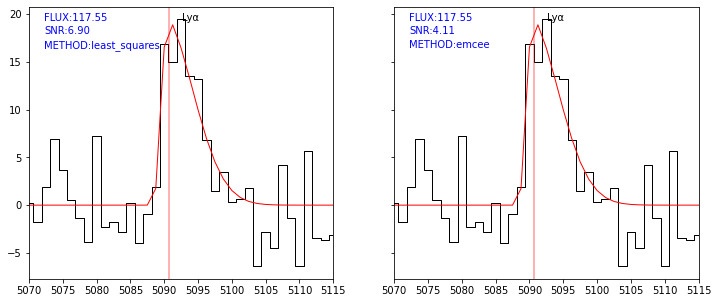

In [29]:
fig,ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
kw = dict(line='LYALPHA', line_only=True, margin=20, infoline=['FLUX','SNR'], infoz=['METHOD'], legend=False)
plot_fit(ax[0], res0, **kw)
plot_fit(ax[1], res1, **kw)

As shown in the plot above the solutions are nearly identical. This is expected given that the MCMC routine use as starting point the least-square solution, and only then explore the parameter space to derive the probability distribution. Note however that the S/N derived is much lower (70%) than the one returned by the least square routine.

To check if the MCMC solution has converged we need to check the autocorrelation time returned by the routine. According to the emcee [documentation](https://emcee.readthedocs.io/en/stable/user/autocorr/), the chain length (Steps) must be large enough with respect to the autocorrelation time (Acor). In practice it is recommended to have $\rm Steps  > 50 \times Acor$ for all parameters. The program print the minimum value of 1.5 for the chain ratio which indicate that we are fine.

We can also have a more detailed view of the returned parameters using the **print_res** function.

In [30]:
print_res(res1, 'lyalpha')

Name,Min_bound,Max_bound,Init_value,Value,Median,Init_Std,Std,Acor,Acor_ratio,Min_p99,Min_p95,Max_p95,Max_p99
bytes40,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
dv_lyalpha,-500.000,500.000,-30.330,-30.329,-22.291,23.283,62.226,136.777,1.462,--,--,--,--
vdisp_lyalpha,50.000,700.000,263.959,263.963,268.039,52.560,93.807,71.923,2.781,--,--,--,--
lyalpha_LYALPHA_asymgauss_l0,-inf,inf,1215.670,1215.670,--,--,nan,--,--,--,--,--,--
lyalpha_LYALPHA_asymgauss_flux,0.000,inf,117.554,117.552,118.398,17.028,28.585,60.648,3.298,--,--,--,--
lyalpha_LYALPHA_asymgauss_asym,-1.000,10.000,8.425,8.436,5.172,6.263,3.442,106.289,1.882,--,--,--,--


The returned table gives detailed information for all model parameters. For each parameter we have the bounds (Min_bound and Max_bound), the initial value and standard deviation (Init_value, Init_Std) which are the one returned by the least-square fit, the maximum likehood value (Value), the median value (Median) of the distribution and the standard deviation (Std). We can also see the autocorrelation time (Acor) and the ratio discussed above (Acor_ratio). If the MCMC has converged we should have Acor_ratio larger than 1 for all parameters. For example the flux error estimate has a very large value of 3.7 and then we can be sure that the errors is well estimated.

We will see later that the parameter Acor_ratio is also returned as **par_RTAU** in the lines table.

Now we run the fit for all lines for the same spectra, using the **mcmc_all** flag.

In [31]:
sp = Spectrum(os.path.join(datadir,'udf10_00723.fits'))
res2 = fit_spec(sp, z=3.18817, mcmc_all=True)

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 16.7 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Init Lya Fit
[DEBUG] added 1 asymetric gaussian to the fit
[DEBUG] Found 1 non resonnant line families to fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 14 lines to fit
[DEBUG] added 14 gaussian to the fit
[DEBUG] Found 1 resonnant line families to fit
[DEBUG] Init fitting of family civ1548
[DEBUG] Found 2 lines to fit
[DEBUG] added 2 gaussian to the fit
[DEBUG] Fitting of Line Family: lya
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 11 iterations, reached minimum = 188.100 and redChi2 = 0.308
[DEBUG] Emcee fitting: {'method': 'emcee', 'is_weighted': True, 'steps': 10000, 'nwalkers': 40, 'progress': True, 'run_mcmc_kwargs': {'skip_initial_state_check': False}}


100%|██████████| 10000/10000 [01:07<00:00, 147.65it/s]


[DEBUG] status 1 after 400000 fcn eval, chain size ratio = 1.4 max autocorr time = 138.7 mean acceptance fraction = 0.52, reached minimum = 188.330 and redChi2 = 0.309
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] Both `ftol` and `xtol` termination conditions are satisfied. after 16 iterations, reached minimum = 209.310 and redChi2 = 0.350
[DEBUG] Emcee fitting: {'method': 'emcee', 'is_weighted': True, 'steps': 10000, 'nwalkers': 160, 'progress': True, 'run_mcmc_kwargs': {'skip_initial_state_check': False}}


100%|██████████| 10000/10000 [10:05<00:00, 16.51it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 16 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [541.08525486 560.23109098 564.97221531 589.7760002  604.77238022
 599.13063577 564.72364103 631.19439833 587.26531009 547.45013994
 535.18327004 531.08699986 543.66747331 692.64174475 582.29966117
 573.46571356]
[DEBUG] status 0 after 1600000 fcn eval, chain size ratio = 0.3 max autocorr time = 692.6 mean acceptance fraction = 0.16, reached minimum = 210.680 and redChi2 = 0.352
[DEBUG] Fitting of Line Family: civ1548
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 14 iterations, reached minimum = 212.787 and redChi2 = 0.349
[DEBUG] Emcee fitting: {'method': 'emcee', 'is_weighted': True, 'steps': 10000, 'nwalkers': 40, 'progress': True, 'run_mcmc_kwargs': {'skip_initial_state_check': False}}


100%|██████████| 10000/10000 [01:07<00:00, 147.82it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [ 98.72656576  88.1923429  551.66378095  82.85389342]
[DEBUG] status 0 after 400000 fcn eval, chain size ratio = 0.4 max autocorr time = 551.7 mean acceptance fraction = 0.43, reached minimum = 214.094 and redChi2 = 0.351
[DEBUG] Saving lya results to tablines and ztab
[DEBUG] Saving forbidden results to tablines and ztab
[DEBUG] Saving civ1548 results to tablines and ztab


One can have a summary of the fit by looking to the ztable

In [32]:
res2['ztable']

FAMILY,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDISP,VDISP_ERR,LINE,SNRMAX,SNRSUM,SNRSUM_CLIPPED,NL,NL_CLIPPED,RCHI2,NFEV,STATUS,METHOD,NSTEPS,RCHAIN,NBAD,RCHAIN_CLIP,NBAD_CLIP
str20,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,int64,int64,float64,int64,int64,str25,int64,float64,int64,float64,int64
civ1548,120.64,257.51,3.18986,3.60e-03,3.18817,50.00,90.10,CIV1549b,1.03,1.03,0.00,1,0,0.35,400000,0,emcee,10000,0.36,1,0.00,0
forbidden,-121.12,212.82,3.18648,2.97e-03,3.18817,300.00,43.73,CIII1909b,1.37,2.17,0.00,8,0,0.35,1600000,0,emcee,10000,0.29,14,0.00,0
lyalpha,37.03,61.41,3.18869,8.58e-04,3.18817,263.95,94.50,LYALPHA,4.16,4.16,4.16,1,1,0.31,400000,1,emcee,10000,1.44,0,1.44,0


One can see from the status value of 0, that the MCMC did not converge for the civ1548 and forbidden families. Indeed the reported value for the chain length ratio (RCHAIN) is below 1. The NBAD column indicate the number of lines that are below 1. All lines have a SNR below 3 as indicated by the zero value of NL_CLIPPED. Note that the SNR value is probably not very reliable because the MCMC did not converge. The velocity dispersion seems also high. We can check this by looking to the bounds value returned by **print_res**.

In [33]:
print_res(res2, 'forbidden')[0:3]

Name,Min_bound,Max_bound,Init_value,Value,Median,Init_Std,Std,Acor,Acor_ratio,Min_p99,Min_p95,Max_p95,Max_p99
bytes40,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
dv_forbidden,-500.000,500.000,-121.113,-121.116,-98.443,151.501,212.816,541.085,0.370,--,--,--,--
vdisp_forbidden,5.000,300.000,300.000,300.000,268.007,124.474,43.731,560.231,0.357,--,--,--,--
forbidden_NV1238_gauss_l0,-inf,inf,1238.820,1238.820,--,--,nan,--,--,--,--,--,--


As shown above, the least-square fit reach the velocity dispersion bounds. Let's run the fit separately to see if we obtain a better solution.

In [34]:
sp = Spectrum(os.path.join(datadir,'udf10_00723.fits'))
res4 = fit_spec(sp, z=3.18817, mcmc_all=True, lines=['CIII1907','CIII1909'])

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 1.8 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Found 1 non resonnant line families to fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 2 lines to fit
[DEBUG] added 2 gaussian to the fit
[DEBUG] Found 0 resonnant line families to fit
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 9 iterations, reached minimum = 19.882 and redChi2 = 0.316
[DEBUG] Emcee fitting: {'method': 'emcee', 'is_weighted': True, 'steps': 10000, 'nwalkers': 40, 'progress': True, 'run_mcmc_kwargs': {'skip_initial_state_check': False}}


100%|██████████| 10000/10000 [01:02<00:00, 160.25it/s]


[DEBUG] status 1 after 400000 fcn eval, chain size ratio = 2.2 max autocorr time = 90.6 mean acceptance fraction = 0.45, reached minimum = 20.584 and redChi2 = 0.327
[DEBUG] Saving forbidden results to tablines and ztab


In [35]:
res4['ztable']

FAMILY,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDISP,VDISP_ERR,LINE,SNRMAX,SNRSUM,SNRSUM_CLIPPED,NL,NL_CLIPPED,RCHI2,NFEV,STATUS,METHOD,NSTEPS,RCHAIN,NBAD,RCHAIN_CLIP,NBAD_CLIP
str20,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,int64,int64,float64,int64,int64,str25,int64,float64,int64,float64,int64
forbidden,-145.81,275.45,3.18613,3.85e-03,3.18817,82.56,81.62,CIII1909b,1.88,1.88,0.00,1,0,0.33,400000,1,emcee,10000,2.21,0,0.00,0


This time the velocity dispersion is ok and the RCHAIN value is ok. This is better shown in the following plot.

In [36]:
ltab = res4['lines']
ltab = ltab[(ltab['LINE']=='CIII1907') | (ltab['LINE']=='CIII1909')]
ltab['LINE','SNR','FLUX','FLUX_RTAU','VDISP']

LINE,SNR,FLUX,FLUX_RTAU,VDISP
str20,float64,float64,float64,float64
CIII1907,1.81,35.07,2.78,82.56
CIII1909,0.52,9.68,2.57,82.56


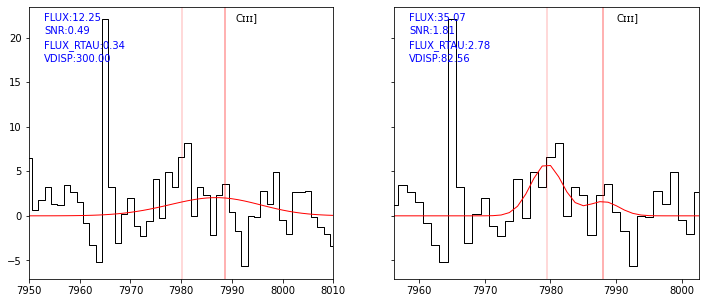

In [37]:
fig,ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
kw = dict(line='CIII1907', line_only=True, margin=20, infoline=['FLUX','SNR','FLUX_RTAU','VDISP'], legend=False)
plot_fit(ax[0], res2, **kw)
plot_fit(ax[1], res4, **kw)

When using the mcmc option, we have access to the full probability distribution of each parameters. The **save_proba** option will save the 95% and 99% bounds for each parameters.
We illustrate this on the double peaked lya fit.

In [38]:
sp = Spectrum(os.path.join(datadir,'udf10_00106.fits'))
res = fit_spec(sp, z=3.27554, dble_lyafit=True, lines=['LYALPHA'], mcmc_lya=True, mcmcpars=dict(save_proba=True))

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 2.0 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Init Lya Fit
[DEBUG] Using double asymetric gaussian model
[DEBUG] added 1 double asymetric gaussian to the fit
[DEBUG] Found 0 non resonnant line families to fit
[DEBUG] Found 0 resonnant line families to fit
[DEBUG] Fitting of Line Family: lya
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 6 iterations, reached minimum = 46.432 and redChi2 = 0.714
[DEBUG] Emcee fitting: {'method': 'emcee', 'is_weighted': True, 'nwalkers': 80, 'steps': 15000}


100%|██████████| 15000/15000 [04:23<00:00, 57.02it/s]


[DEBUG] status 1 after 1200000 fcn eval, chain size ratio = 2.9 max autocorr time = 104.0 mean acceptance fraction = 0.45, reached minimum = 46.544 and redChi2 = 0.716
[DEBUG] Saving lya results to tablines and ztab


In [39]:
print_res(res, 'lyalpha')

Name,Min_bound,Max_bound,Init_value,Value,Median,Init_Std,Std,Acor,Acor_ratio,Min_p99,Min_p95,Max_p95,Max_p99
bytes40,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
dv_lyalpha,-500.000,500.000,34.180,34.180,34.322,4.830,6.004,99.306,3.021,18.631,23.813,43.845,47.609
vdisp1_lyalpha,50.000,700.000,194.328,194.328,196.747,11.931,14.144,97.622,3.073,161.349,172.647,219.466,228.691
vdisp2_lyalpha,50.000,700.000,307.577,307.573,310.093,11.401,13.922,90.696,3.308,277.056,286.807,332.983,342.585
lyalpha_LYALPHA_dbleasymgauss_l0,-inf,inf,1215.670,1215.670,--,--,nan,--,--,--,--,--,--
lyalpha_LYALPHA_dbleasymgauss_sep,80.000,1000.000,515.832,515.824,514.100,9.661,12.016,93.543,3.207,488.013,495.379,535.335,546.170
lyalpha_LYALPHA_dbleasymgauss_flux1,0.000,inf,680.343,680.276,680.454,21.032,24.479,93.007,3.226,624.079,640.423,721.332,738.500
lyalpha_LYALPHA_dbleasymgauss_flux2,0.000,inf,1080.472,1080.467,1080.721,26.045,30.629,85.384,3.514,1010.139,1030.766,1131.562,1153.228
lyalpha_LYALPHA_dbleasymgauss_asym1,-10.000,0.000,-2.776,-2.777,-2.901,0.497,0.669,104.038,2.884,-5.056,-4.234,-1.945,-1.577
lyalpha_LYALPHA_dbleasymgauss_asym2,0.000,10.000,4.040,4.041,4.237,0.584,0.817,93.245,3.217,2.739,3.115,5.880,6.853


More information is available (see [here](https://lmfit.github.io/lmfit-py/fitting.html#minimizer-emcee-calculating-the-posterior-probability-distribution-of-parameters)). For example we can visualize the posterior distributions for the parameters using the corner package:

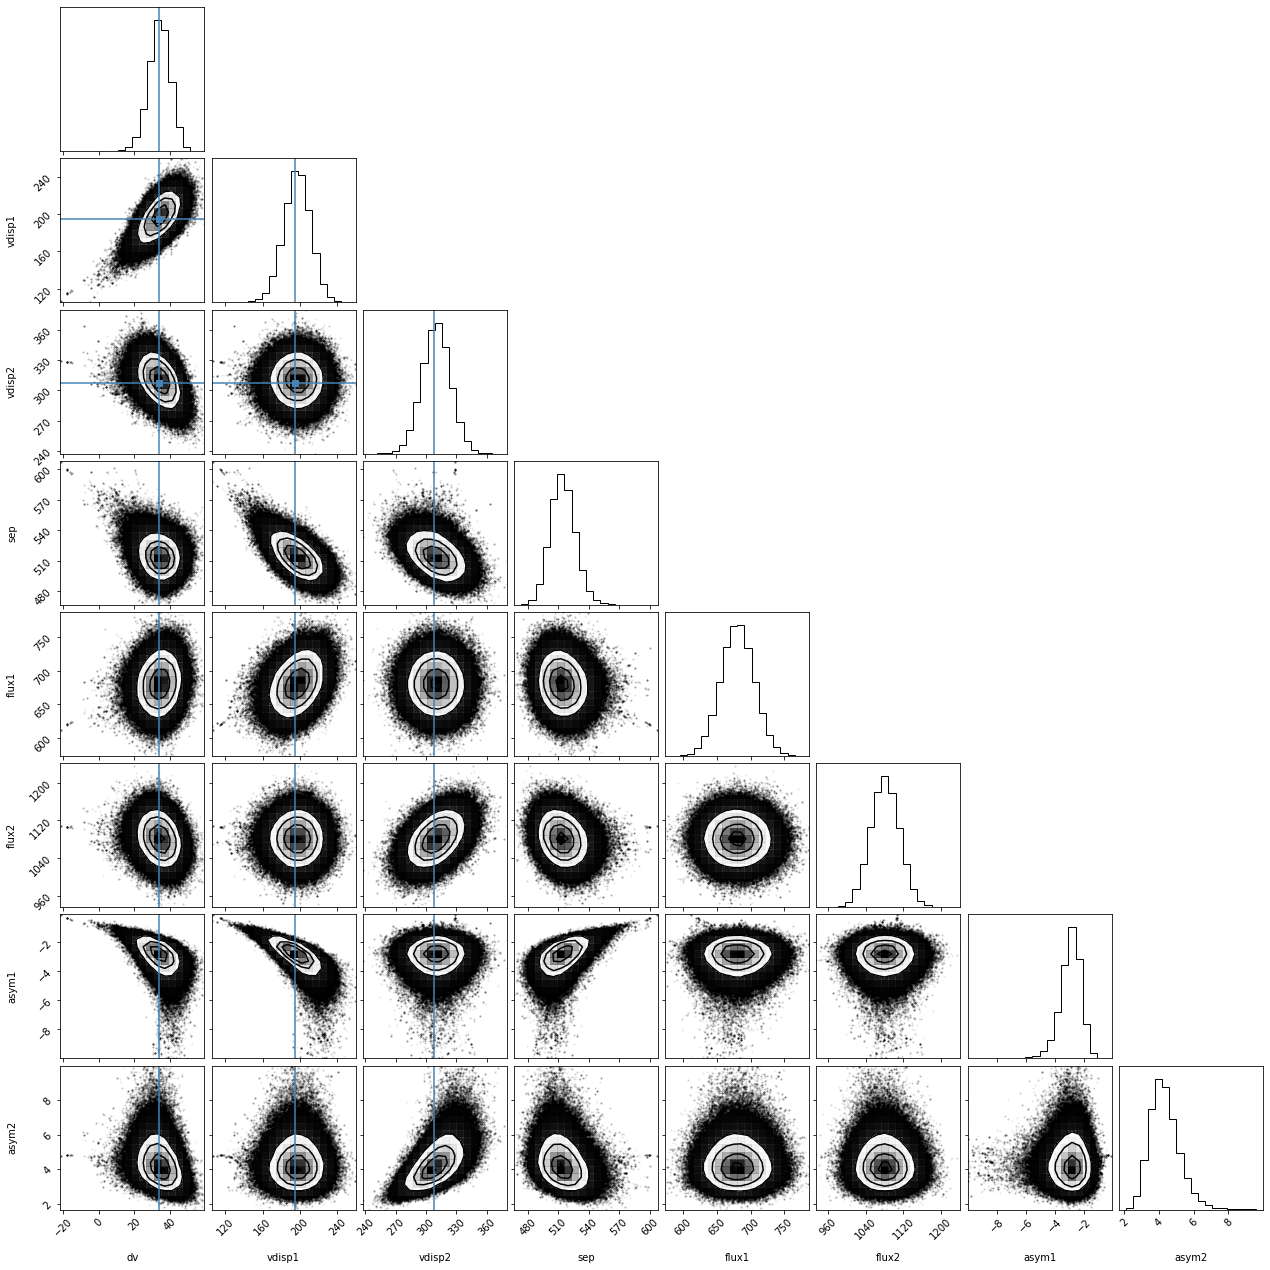

In [40]:
import corner
lmres = res['dline']['lmfit_lya']
names = [e.split('_')[0] for e in lmres.var_names[0:3]] + [e.split('_')[-1] for e in lmres.var_names[3:]]
emcee_plot = corner.corner(lmres.flatchain, labels=names,
                           truths=list(lmres.params.valuesdict().values()))

### Selecting and updating emission/absorption lines

The program comes with a default line list and provide options to select, adapt and update the line list.

The default line astropy table can be returned by the **get_lines** function.

In [41]:
from pyplatefit import get_lines
get_lines(orig=True)

LINE,FAMILY,LBDA_REST,DOUBLET,MAIN,EMI,ABS,RESONANT,DNAME
bytes9,bytes9,float32,int64,bool,bool,bool,bool,bytes10
OVI1032,forbidden,1031.91,1033,False,True,False,False,None
OVI1038,forbidden,1037.61,1033,False,True,False,False,Ovɪ
LYALPHA,balmer,1215.67,0,True,True,False,True,Lyα
NV1238,forbidden,1238.82,1240,False,True,False,False,None
NV1242,forbidden,1242.8,1240,False,True,False,False,NV
SiII1260,ism,1260.42,0,False,False,True,False,Siɪɪ
OI1302,ism,1302.17,1303,False,False,True,False,Oɪ
SiII1304,ism,1304.37,1303,False,False,True,False,Siɪɪ
CII1334,ism,1334.53,0,False,False,True,False,Cɪɪ


These table contains the following columns:


- LINE: the line name. There are no official naming convention for the line but we try to pick up the most commo names currently used.
- FAMILY: the family name, currently we have balmer, forbidden and ism.
- LBDA_REST: the vacuum wavelength rest frame
- DOUBLET: an integer which indicate if non zero, that the line is part of a multiplet. All lines with identical values are belonging to the same multiplet.
- MAIN: a boolean flag, indicate if the line is considered as a main line. 
- EMI: a boolean flag for emission line.
- ABS: a boolean flag for absorption lines.
- RESONNANT: a boolean flag for resonnant lines.
- DNAME: display name used for plots.

When performing the fit it is possible to restrict the fit to some lines.

The option flag **major_lines=True** wil only fit the main lines.

In [42]:
sp = Spectrum(os.path.join(datadir,'udf10_00723.fits'))
res = fit_spec(sp, z=3.18817, major_lines=True)

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 5.3 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Init Lya Fit
[DEBUG] added 1 asymetric gaussian to the fit
[DEBUG] Found 1 non resonnant line families to fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 2 lines to fit
[DEBUG] added 2 gaussian to the fit
[DEBUG] Found 1 resonnant line families to fit
[DEBUG] Init fitting of family civ1548
[DEBUG] Found 2 lines to fit
[DEBUG] added 2 gaussian to the fit
[DEBUG] Fitting of Line Family: lya
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 11 iterations, reached minimum = 65.515 and redChi2 = 0.343
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 9 iterations, reached minimum = 88.991 and r

In [43]:
res['lines']

FAMILY,LINE,ISBLEND,LBDA_REST,DNAME,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDINST,VDISP,VDISP_ERR,FLUX,FLUX_ERR,SNR,SKEW,SKEW_ERR,LBDA_OBS,PEAK_OBS,LBDA_LEFT,LBDA_RIGHT,FWHM_OBS,NSTD,LBDA_LNSTD,LBDA_RNSTD,BLEND,EQW,EQW_ERR,CONT_OBS,CONT,CONT_ERR
str20,str20,bool,float64,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
lyalpha,LYALPHA,False,1215.67,Lyα,37.03,23.18,3.18869,3.24e-04,3.18817,65.68,263.96,52.32,117.55,16.95,6.94,8.42,6.23,5090.64,19.33,5089.47,5095.13,5.66,-1.57,5087.12,5104.10,0,--,--,-0.02,-0.08,14.53
civ1548,CIV1548,False,1548.20,None,120.59,58.91,3.18985,8.23e-04,3.18817,46.46,50.05,79.86,0.00,7.19,0.00,0.00,0.00,6484.94,0.00,6483.20,6486.68,3.48,-0.90,6479.72,6500.92,1549,--,--,-0.09,-0.38,11.46
civ1548,CIV1549b,True,1549.48,Cɪᴠ,120.59,58.91,3.18985,8.23e-04,3.18817,0.00,50.05,79.86,15.61,11.77,1.33,0.00,0.00,6490.32,4.21,6483.20,6497.44,3.48,0.00,0.00,0.00,1549,--,--,-0.11,-0.48,11.38
civ1548,CIV1550,False,1550.77,Cɪᴠ,120.59,58.91,3.18985,8.23e-04,3.18817,46.36,50.05,79.86,15.61,11.77,1.33,0.00,0.00,6495.70,4.21,6493.96,6497.44,3.48,-0.90,6479.72,6500.92,1549,--,--,-0.12,-0.50,11.37
forbidden,CIII1907,False,1906.68,None,-145.80,44.00,3.18613,6.15e-04,3.18817,36.73,82.54,38.21,35.07,16.11,2.18,0.00,0.00,7979.42,5.82,7976.59,7982.25,5.66,-1.17,7970.92,7996.50,1909,--,--,-0.08,-0.32,13.28
forbidden,CIII1909b,True,1907.71,Cɪɪɪ],-145.80,44.00,3.18613,6.15e-04,3.18817,0.00,82.54,38.21,44.75,18.52,2.42,0.00,0.00,7983.71,5.82,7976.59,7990.83,5.67,0.00,0.00,0.00,1909,--,--,-0.08,-0.35,13.26
forbidden,CIII1909,False,1908.73,Cɪɪɪ],-145.80,44.00,3.18613,6.15e-04,3.18817,36.70,82.54,38.21,9.68,9.22,1.05,0.00,0.00,7988.00,1.60,7985.16,7990.83,5.67,-1.17,7970.92,7996.50,1909,--,--,-0.08,-0.33,13.29


It is also possible to fit only a subset of lines by providing the list of lines to fit

In [44]:
res = fit_spec(sp, z=3.18817, lines=['LYALPHA','CIII1907','CIII1909'])
res['lines']

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 3.7 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Init Lya Fit
[DEBUG] added 1 asymetric gaussian to the fit
[DEBUG] Found 1 non resonnant line families to fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 2 lines to fit
[DEBUG] added 2 gaussian to the fit
[DEBUG] Found 0 resonnant line families to fit
[DEBUG] Fitting of Line Family: lya
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 11 iterations, reached minimum = 46.069 and redChi2 = 0.344
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 9 iterations, reached minimum = 69.546 and redChi2 = 0.519
[DEBUG] Saving lya results to tablines and ztab
[DEBUG] Saving forbidden results to tabli

FAMILY,LINE,ISBLEND,LBDA_REST,DNAME,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDINST,VDISP,VDISP_ERR,FLUX,FLUX_ERR,SNR,SKEW,SKEW_ERR,LBDA_OBS,PEAK_OBS,LBDA_LEFT,LBDA_RIGHT,FWHM_OBS,NSTD,LBDA_LNSTD,LBDA_RNSTD,BLEND,EQW,EQW_ERR,CONT_OBS,CONT,CONT_ERR
str20,str20,bool,float64,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
lyalpha,LYALPHA,False,1215.67,Lyα,37.03,23.20,3.18869,3.24e-04,3.18817,65.68,263.96,52.38,117.55,16.97,6.93,8.42,6.24,5090.64,19.33,5089.47,5095.13,5.66,-1.57,5087.12,5104.10,0,--,--,-0.02,-0.08,14.53
forbidden,CIII1907,False,1906.68,None,-145.80,46.43,3.18613,6.49e-04,3.18817,36.73,82.54,40.33,35.07,17.00,2.06,0.00,0.00,7979.42,5.82,7976.59,7982.25,5.66,-1.17,7970.92,7996.50,1909,--,--,-0.08,-0.32,13.28
forbidden,CIII1909b,True,1907.71,Cɪɪɪ],-145.80,46.43,3.18613,6.49e-04,3.18817,0.00,82.54,40.33,44.75,19.54,2.29,0.00,0.00,7983.71,5.82,7976.59,7990.83,5.67,0.00,0.00,0.00,1909,--,--,-0.08,-0.35,13.26
forbidden,CIII1909,False,1908.73,Cɪɪɪ],-145.80,46.43,3.18613,6.49e-04,3.18817,36.70,82.54,40.33,9.68,9.73,0.99,0.00,0.00,7988.00,1.60,7985.16,7990.83,5.67,-1.17,7970.92,7996.50,1909,--,--,-0.08,-0.33,13.29


Finally, it is also possible to provide its own table. It must have the same format than the default table.

In the following example, we retreive the default lines table and set the RESONNANT flag to False for the CIV1548,1550 lines. We then run fit_spec and provide the modified lines table. Now the CIV doublet is fitted together with the other forbidden lines.

In [45]:
mylines = get_lines(orig=True)
mylines['RESONANT'][(mylines['LINE']=='CIV1548') | (mylines['LINE']=='CIV1550')] = False
res = fit_spec(sp, z=3.18817, lines=mylines, major_lines=True)
res['ztable']

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from user line table...
[DEBUG] 5.3 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Init Lya Fit
[DEBUG] added 1 asymetric gaussian to the fit
[DEBUG] Found 1 non resonnant line families to fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 4 lines to fit
[DEBUG] added 4 gaussian to the fit
[DEBUG] Found 0 resonnant line families to fit
[DEBUG] Fitting of Line Family: lya
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 11 iterations, reached minimum = 65.515 and redChi2 = 0.343
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 22 iterations, reached minimum = 88.646 and redChi2 = 0.469
[DEBUG] Saving lya results to tablines and ztab
[DEBUG] Saving forbidden results to tabline

FAMILY,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDISP,VDISP_ERR,LINE,SNRMAX,SNRSUM,SNRSUM_CLIPPED,NL,NL_CLIPPED,RCHI2,NFEV,STATUS,METHOD
str20,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,int64,int64,float64,int64,int64,str25
forbidden,121.00,155.52,3.18986,2.17e-03,3.18817,172.35,133.22,CIV1549b,1.35,1.79,0.00,2,0,0.47,22,3,least_squares
lyalpha,37.03,23.18,3.18869,3.24e-04,3.18817,263.96,52.32,LYALPHA,6.94,6.94,6.94,1,1,0.34,11,3,least_squares


### Adjusting fit parameters

A number of parameters can be changed to adapt the fitting parameters, update bounds, add new line ratios, etc. 
These parameters are given to **fit_spec** as python dictionary.

The **linepars** dictionary is used to define bounds and line ratios of the fitted variable. It can have the following items:
- **vel** = (vmin,vinit,vmax): bounds and initial values of the velocity with respect to the given redshift. Default is (-500,0,500) km/s. Used for all line families except absorption lines.

- **vdisp** = (vmin,vinit,vmax): bounds and initial values of the rest-frame velocity dispersion. Default is (5,50,300) km/s. Used for all line families except ${\rm Ly\alpha}$ and absorption lines.

- **velabs** = (vmin,vinit,vmax): bounds and initial values of the velocity with respect to the given redshift. Default is (-500,0,500) km/s. Used for absorption lines.

- **vdispabs** = (vmin,vinit,vmax): bounds and initial values of the rest-frame velocity dispersion. Default is (5,50,300) km/s. Used for absorption lines.

- **vdisp_lya** = (vmin,vinit,vmax): bounds and initial values of the rest-frame ${\rm Ly\alpha}$ velocity dispersion. Default is (50,150,700) km/s. 
- **gamma_lya** = (vmin,vinit,vmax): bounds and initial values of the skewed ${\rm \gamma \, Ly\alpha}$ parameter. Default is (-1,0,10). 
- **sep_2lya** = (vmin,vinit,vmax): bounds and initial values of the peak separation for double  ${\rm Ly\alpha}$ fit. Default is (80,500,1000) km/s. 
- **gamma_2lya1** = (vmin,vinit,vmax): bounds and initial values of the skewed ${\rm \gamma \, Ly\alpha}$ parameter for the blue line. Default is (-10,-2,0). 
- **gamma_2lya2** = (vmin,vinit,vmax): bounds and initial values of the skewed ${\rm \gamma \, Ly\alpha}$ parameter for the red line. Default is (0,2,10).
- **line_ratios** = list of lines ratio bounds. default is [("CIII1907", "CIII1909", 0.6, 1.2),("OII3726", "OII3729", 0.3, 1.5)]
- **polydegabs** = polynomial degree for continuum fit prior to absorption fit, default 12
- **polyiterabs** = maximum of sig-clip iteration for continuum fit prior to absorption fit, default 3
- **polywmask** = window half size used form masking in polynomial fit prior to absorption fit, default 3.0 Angstroem
- **windmax** = window half size to find peak to estimate initial value for the fitting process (default 10 Angstroem)
- **minsnr** = minimum SNR value used to clip for ztable computation, default 3.0
- **nstd_relsize** = relative size with respect to FWHM for line NSTD estimate, default 3.0

Additional parameters for the MCMC error estimate are given in the **mcmpars** dictionary:
- **steps** = length of the MCMC chain. Default is 0, which translate to 10000, except for double $/rm Ly\alpha$ fit where it is 15000. If the process has not converged this is the parameter to adjust.
- **progress** = display a running bar (True/False), default True
- **nworkers** = number of workers. Dafult is 0, which translate to ten times the number of fitted parameters
- **save_proba** = if True, save the 1%, 5%, 95% and 99% percentile for all variables.

For example to constrain the velocity dispersion and the emission line ratio between MgII2796,2803 you have to run the following.

In [46]:
sp = Spectrum(os.path.join(datadir,'DR2_001028.fits'))
ratio = [("MgII2796", "MgII2803", 0.5, 1.5)]
params = dict(line_ratios=ratio, vdisp=(5,10,50))
res = fit_spec(sp, z=1.90578, linepars=params)

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 12.7 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Found 1 non resonnant line families to fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 15 lines to fit
[DEBUG] added 15 gaussian to the fit
[DEBUG] Found 1 resonnant line families to fit
[DEBUG] Init fitting of family mgii2796
[DEBUG] Found 2 lines to fit
[DEBUG] added 2 gaussian to the fit
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 17 iterations, reached minimum = 569.896 and redChi2 = 1.264
[DEBUG] Fitting of Line Family: mgii2796
[DEBUG] Lmfit fitting: {'method': 'least_square', 'xtol': 0.001}
[DEBUG] `xtol` termination condition is satisfied. after 13 iterations, reached minimum = 599.141 and redChi2 = 1.291
[DEBUG] Saving forbidden results to tabl

In [47]:
res['ztable']

FAMILY,VEL,VEL_ERR,Z,Z_ERR,Z_INIT,VDISP,VDISP_ERR,LINE,SNRMAX,SNRSUM,SNRSUM_CLIPPED,NL,NL_CLIPPED,RCHI2,NFEV,STATUS,METHOD
str20,float64,float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,int64,int64,float64,int64,int64,str25
forbidden,-64.30,20.15,1.90516,1.95e-04,1.90578,50.00,22.80,CII2326b,4.62,4.62,4.62,8,1,1.26,17,3,least_squares
mgii2796,274.95,16.10,1.90845,1.56e-04,1.90578,50.00,20.03,MgII2799b,4.74,4.74,4.74,1,1,1.29,13,3,least_squares


The **minpars** dictionary is used for the minimization process with lmfit. The default items are:
- **method** = 'least_squares', name of the lmfit minimization method
- **xtol** = 0.001, tolerance requested on fitted parameters

The name of parameters are function of the selected minimization, see [lmfit minimization](https://lmfit.github.io/lmfit-py/fitting.html) and [scipy minimization](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize) for the list of minimization and associated parameters.

For example, to add a tolerance on the residual and a maxmim number number of function evaluation, given [scipy least_squares documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) we will use the following:

In [48]:
params = dict(method='least_squares', xtol=1.e-3, ftol=1.e-3, max_nfev=200)
logger.setLevel('DEBUG')
res = fit_spec(sp, z=1.90578, minpars=params)
logger.setLevel('INFO')

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 12.7 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Found 1 non resonnant line families to fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 15 lines to fit
[DEBUG] added 15 gaussian to the fit
[DEBUG] Found 1 resonnant line families to fit
[DEBUG] Init fitting of family mgii2796
[DEBUG] Found 2 lines to fit
[DEBUG] added 2 gaussian to the fit
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'least_squares', 'xtol': 0.001, 'ftol': 0.001, 'max_nfev': 200}
[DEBUG] `ftol` termination condition is satisfied. after 6 iterations, reached minimum = 567.640 and redChi2 = 1.259
[DEBUG] Fitting of Line Family: mgii2796
[DEBUG] Lmfit fitting: {'method': 'least_squares', 'xtol': 0.001, 'ftol': 0.001, 'max_nfev': 200}
[DEBUG] `ftol` termination condition is satisfied. after 23 iterations, reached minimum = 599

We can also use try a different minimization routine. For example, the Nelder-Mead simplex algorithm. *But note that it use a much larger number of iterations.*

In [49]:
params = dict(method='nelder', options=dict(xtol=1.e-3))
logger.setLevel('DEBUG')
res = fit_spec(sp, z=1.90578, minpars=params)
logger.setLevel('INFO')

[DEBUG] Fit continuum
[DEBUG] Fit emission lines
[DEBUG] Preparing data for fit
[DEBUG] Getting lines from default line table...
[DEBUG] 12.7 % of the spectrum is used for fitting.
[DEBUG] Initialize fit
[DEBUG] Found 1 non resonnant line families to fit
[DEBUG] Init Fit of family forbidden
[DEBUG] Found 15 lines to fit
[DEBUG] added 15 gaussian to the fit
[DEBUG] Found 1 resonnant line families to fit
[DEBUG] Init fitting of family mgii2796
[DEBUG] Found 2 lines to fit
[DEBUG] added 2 gaussian to the fit
[DEBUG] Fitting of Line Family: forbidden
[DEBUG] Lmfit fitting: {'method': 'nelder', 'options': {'xtol': 0.001}}
[DEBUG] Maximum number of function evaluations has been exceeded. after 3401 iterations, reached minimum = 571.309 and redChi2 = 1.267
[DEBUG] Fitting of Line Family: mgii2796
[DEBUG] Lmfit fitting: {'method': 'nelder', 'options': {'xtol': 0.001}}
[DEBUG] Optimization terminated successfully. after 172 iterations, reached minimum = 637.016 and redChi2 = 1.373
[DEBUG] Savin

### LSF

By default, the reported rest frame velocity dispersion are corrected from the instrumental LSF. It is possible to disable this correction by settings **lsf=None** in fit_spec.

The LSF model is the following MUSE LSF model:
${\rm FWHM \left(\lambda\right) = 5.19939 - 7.56746 \, 10^{-04} \lambda + 4.93397 \, 10^{-08} \lambda^2}$ with FWHM in Angstroem.


It is possible to use its own LSF model by giving his own function ${\rm FWHM \left(\lambda\right)}$, like in the following:

In [50]:
import numpy as np
def mylsf(lbda):
    return np.interp(lbda, [4750,9300], [3.5,3.2])

logger.setLevel('INFO')
sp = Spectrum(os.path.join(datadir, 'udf10_00002.fits'))
res0 = fit_spec(sp, z=0.41892)
res1 = fit_spec(sp, z=0.41892, lsf=mylsf)
res2 = fit_spec(sp, z=0.41892, lsf=None)
for res in [res0,res1,res2]:
    lines = res['lines']
    r = lines[lines['LINE']=='OIII5007'][0]
    vdinst = r['VDINST'] if 'VDINST' in lines.columns else 0
    print(f"VDINST={vdinst:.2f} VDISP={r['VDISP']:.2f} FWHM_OBS={r['FWHM_OBS']:.2f}")

VDINST=41.44 VDISP=66.65 FWHM_OBS=4.38
VDINST=59.91 VDISP=54.75 FWHM_OBS=4.53
VDINST=0.00 VDISP=84.04 FWHM_OBS=4.69


### Advanced usage

To perform specific operation, one could use the Pyplatefit class. See the class documentation.

Here is an example:

(400.0, 1500.0)

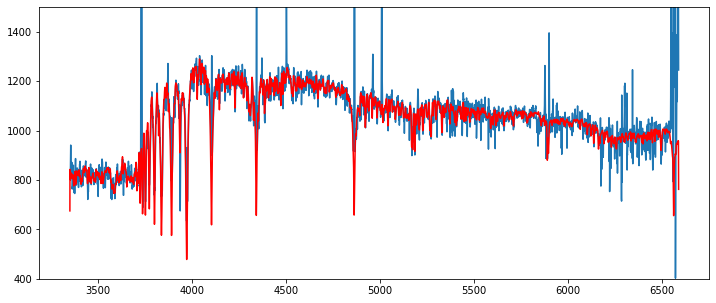

In [51]:
from pyplatefit import Platefit
pf = Platefit()
sp = Spectrum(os.path.join(datadir,'udf10_00002.fits'))
z = 0.41892
rescont = pf.fit_cont(sp, z, vdisp=80)
fig,ax = plt.subplots(1,1,figsize=(12,5))
tab = rescont['table_spec']
ax.plot(tab['RESTWL'],tab['FLUX'])
ax.plot(tab['RESTWL'],tab['CONT'], '-r')
ax.set_ylim(400,1500)

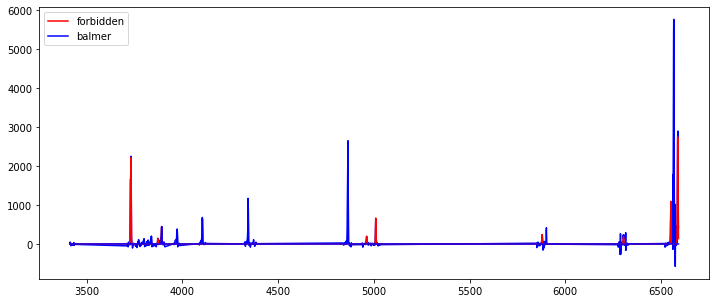

In [52]:
resline = pf.fit_lines(rescont['line_spec'], z)
fig,ax = plt.subplots(1,1,figsize=(12,5))
tab = resline['table_spec']
ax.plot(tab['RESTWL'],tab['FLUX'], '-b')
ax.plot(tab['RESTWL'],tab['FORBIDDEN_FIT_LSQ'], '-r', label='forbidden')
ax.plot(tab['RESTWL'],tab['BALMER_FIT_LSQ'], '-b', label='balmer')
ax.legend()

### Output results in detail

The dictionary return by **fit_spec** contain the following items:

- ztable: the redshift table (see **fit_spec** in the doc main menu for the meaning of table columns)
- lines: the lines table (see **fit_spec** in the doc main menu for the meaning of table columns)
- spec: the input spectrum
- spec_fit: the full fit spectrum (cont_fit + line_fit + abs_fit)
- cont_spec: the fitted model continuum + smooth low order residual spectrum
- cont_fit: the fitted model continuum spectrum
- line_spec: the emission line spectrum after subtraction of the fitted continuum (spec - cont_spec) 
- line_fit: the emission line fit spectrum
- line_initfit: the initial solution for the emission line fit
- abs_cont: the polynomial continuum fit spectrum
- abs_init: the initial solution for the absorption fit (spec - abs_cont)
- abs_fit: the fitted absorption lines spectrum
- dline: dictionary with detailed results for the  emission or absorption lines fit 
- dcont: dictionary with detailed results for the continuum fit

The dictionary **dline** contain the following items:

- table_spec: rest frame emission line table data used in the fitting process
- abs_table_spec: rest frame ansorption line table data used in the fitting process
- lmfit_*family*: [lmfit raw result](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult) with *family*, the family name.

The dictionary **dcont** contain the following items:

- table_spec: rest frame flux table data used in the fitting process
- success: boolean True if fit was successful
- status: output fit message
- z: metallicity for the best fit
- ebv: E(B-V)
- init_z: used redshift for the fit
- chi2: $\chi^2$ fit
- ages: return list of ages for the model library
- weights: returned list of weights for the model library

For example to display the detail lmfit result for the balmer family one can do (check [lmfit](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult) for all the available info):

In [53]:
sp = Spectrum(os.path.join(datadir, 'udf10_00002.fits'))
res = fit_spec(sp, z=0.41892)
res['dline']['lmfit_balmer']